In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import re

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import PolynomialFeatures

In [2]:
link = r"C:\Users\Asus\Jupyter Lab\Home work with ITA\credit_train_after_processing.csv"
all_data = pd.read_csv(filepath_or_buffer=link, index_col='Unnamed: 0')

In [3]:
data = all_data.sample(n=5000, random_state=23)

In [4]:
y = data.open_account_flg.to_frame()
X = data.drop(columns='open_account_flg')
del all_data

### StandartScaler к непрерывным переменным

In [5]:
continuous_variable_names = ['age', 'monthly_income', 'credit_count', 'overdue_credit_count', 'credit_sum', 'credit_month', 'score_shk']

Для выявления профиля клиента, те для определения характеристик кластера данные, которые подвергаются обработке я сохраняю отдельным объектом.
<br>`X_working` - рабочий набор. Он будет подвергаться разного рода обработкам, отображение данных в нем исказится 

In [6]:
scaler = StandardScaler()
scaler_data = pd.DataFrame(scaler.fit_transform(X[continuous_variable_names]), columns=continuous_variable_names)
X_working = X.copy()
X_working[continuous_variable_names] = scaler.fit_transform(X[continuous_variable_names])
del scaler_data

### Приминение PolynomialFeatures

In [7]:
columns_living_region_poly = [i for i in X_working.columns if re.match(pattern='living_region', string=i)]

In [8]:
# columns_poly = [i for i in X_working.columns if i not in columns_not_poly]

In [9]:
columns_living_region_poly = columns_living_region_poly[:50]

In [10]:
poly = PolynomialFeatures(2)

X_poly = pd.DataFrame(data=poly.fit_transform(X_working[columns_living_region_poly]), columns=poly.get_feature_names())
X_working.drop(columns=columns_living_region_poly, inplace=True)

for i in X_poly.columns:
    X_working[i] = X_poly[i].values
del X_poly

## PCA  и выявление оптимального числа компонент по графику каменной осыпи 

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных.

In [11]:
pca = PCA()
pca.fit(X_working)
X_working_pca = pca.transform(X_working)

In [12]:
X_working_pca=scaler.fit_transform(X_working_pca)

Ради интереса, визуализируем данные после применения `tsne`

In [13]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X_working_pca)

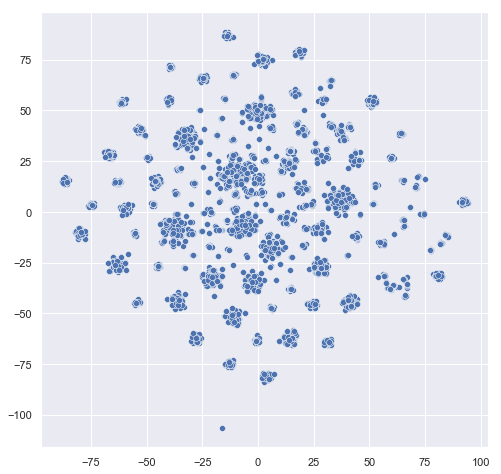

In [14]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1]);

На рисунке, который отображает данные, можно хорошо различить наличие нескольких кластеров. По крайней мере можно различить 6 групп.
Посмотрим график каменистой осыпи.

###  Клиентский профиль на основе open_account_flg

In [14]:
d1 = {i: lambda x: x.median()
     for i in X.columns.delete(loc=X.columns.get_indexer(['gender_M', 'gender_F'])) if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in X.columns.delete(loc=X.columns.get_indexer(['gender_M', 'gender_F'])) if not i in continuous_variable_names}
d1.update(d2)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

data_for_client_profile = data.copy()
data_for_client_profile.drop(columns='gender_M', inplace=True)
data_for_client_profile.rename(columns={'gender_F':'gender'}, inplace=True)
data_for_client_profile['gender'] = data_for_client_profile['gender'].map(lambda x: 'M' if x == 0 else 'F')

client_profile = data_for_client_profile.groupby(['open_account_flg', 'gender']).agg(d1)
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
client_profile[mas]

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  after removing the cwd from sys.path.


age  credit_sum  credit_month  monthly_income  \
open_account_flg gender                                                   
0                F       37.0     20593.0            10         30000.0   
                 M       33.0     22304.5            10         40000.0   
1                F       35.0     18689.0            10         28400.0   
                 M       31.0     20739.0            10         38000.0   

                         marital_status_UNM  marital_status_MAR  \
open_account_flg gender                                           
0                F                28.949772           51.369863   
                 M                29.158004           62.162162   
1                F                32.289157           46.024096   
                 M                39.278132           50.530786   

                         marital_status_DIV  marital_status_CIV  \
open_account_flg gender                                           
0                F                12.785388            2.511416   
                 M                 6.860707            1.663202   
1                F                14.698795            3.855422   
                 M                 7.218684            2.335456   

                         job_position_UMN  job_position_SPC  job_position_PNA  \
open_account_flg gender                                                         
0                F               9.086758         81.095890          2.420091   
                 M              10.758836         79.417879          0.779626   
1                F              11.566265         71.807229          7.951807   
                 M              11.889597         74.097665          3.609342   

                         job_position_BIS  tariff_id_1.6  tariff_id_1.5  \
open_account_flg gender                                                   
0                F               3.287671      23.196347       4.429224   
                 M               3.690229      24.012474       4.781705   
1                F               2.168675      14.457831       2.650602   
                 M               3.821656      18.259023       3.609342   

                         tariff_id_1.4  tariff_id_1.32  tariff_id_1.1  \
open_account_flg gender                                                 
0                F            6.894977        6.666667      40.502283   
                 M            7.224532        6.964657      37.993763   
1                F            2.650602       21.927711      48.192771   
                 M            3.821656       20.806794      43.949045   

                         education_UGR  education_SCH  education_GRD  \
open_account_flg gender                                                
0                F            5.114155      47.808219      46.803653   
                 M            6.808732      51.559252      41.372141   
1                F            5.060241      56.385542      38.313253   
                 M            6.794055      61.358811      30.573248   

                         living_region_ТАТАРСТАН  \
open_account_flg gender                            
0                F                      4.840183   
                 M                      4.885655   
1                F                      3.132530   
                 M                      4.458599   

                         living_region_СТАВРОПОЛЬСКИЙ  \
open_account_flg gender                                 
0                F                           3.105023   
                 M                           3.118503   
1                F                           2.168675   
                 M                           2.760085   

                         living_region_СВЕРДЛОВСКАЯ  \
open_account_flg gender                               
0                F                         3.150685   
                 M                         3.170478   
1                F                         1.686747   
                 M          

In [15]:
del d1
del d2
del client_profile

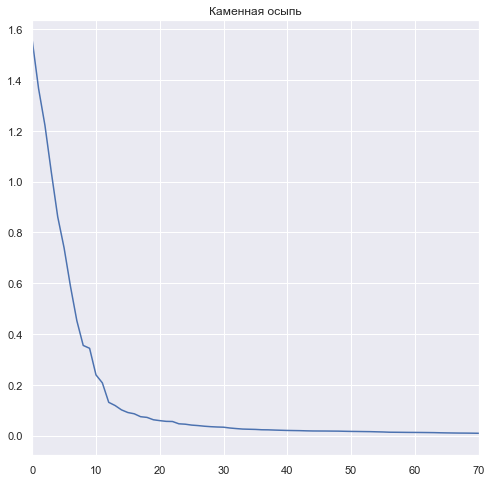

In [19]:
plt.plot(pca.explained_variance_)
plt.title(label='Каменная осыпь')
plt.xlim(0, 70);

In [20]:
pca_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pca_explained_variance_ratio, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
optimal = (np.where(pca_explained_variance_ratio ==
                    pca_explained_variance_ratio[pca_explained_variance_ratio>0.9][0])[0][0], 0.9)
plt.axvline(optimal[0], c='r', lw=1)
plt.axhline(optimal[1], c='r', lw=1)
plt.scatter(x=optimal[0], y=optimal[1], marker='o', c='r', )
plt.annotate(s='{label}'.format(label=optimal),
                 xy=(optimal[0] + 2, optimal[1] + 0.005))
plt.show();

Проанализировав два этих графика: 
1. Устанавливаю число компонент 50 и смотрю как ведут себя данные;
2. устанавливаю число компонент равным 21.


Удаляю `X_working_pca` `X_tsne`

In [21]:
del X_working_pca
del X_tsne
del pca

In [22]:
pca = PCA(n_components=20)
pca.fit(X_working)
X_working_pca_20 = scaler.fit_transform(pca.transform(X_working))
X_tsne_20 = tsne.fit_transform(X_working_pca_20)

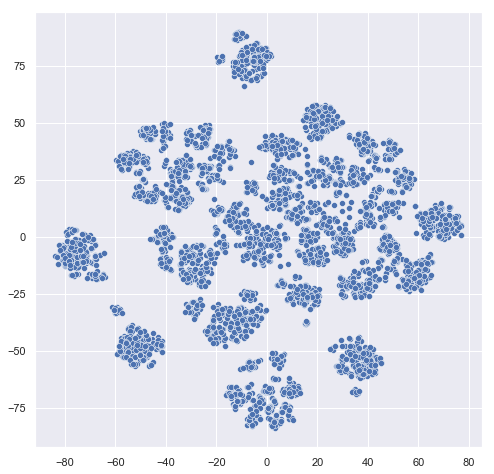

In [23]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x=X_tsne_20[:, 0], y=X_tsne_20[:, 1]);

In [24]:
pca = PCA(n_components=10)
pca.fit(X_working)
X_working_pca_10 = scaler.fit_transform(pca.transform(X_working))
X_tsne_10 = tsne.fit_transform(X_working_pca_10)

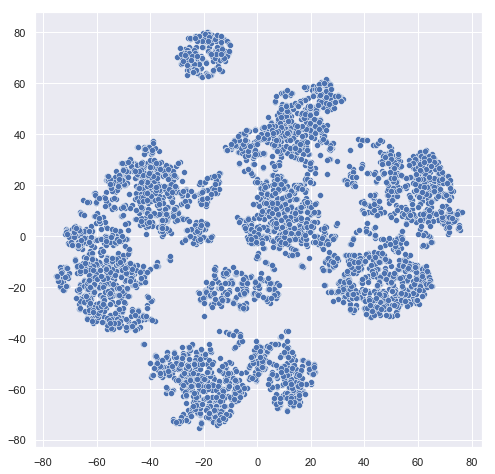

In [25]:
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x=X_tsne_10[:, 0], y=X_tsne_10[:, 1]);

Обращаю внимание на весь слившиеся группы данных при числе компонент равным 21.
<br>В дальнейшем использую `PCA` с 50-ю компонентами  


In [30]:
# X_working_pca = X_working_pca_10.copy()
# X_tsne = X_tsne_56.copy()

# del X_working_pca_10
# del X_working_pca_56,
# del X_tsne_10
# del X_tsne_56

## Работа с алгоритмами
Посмотрим, как работают алгоритмы кластеризации. В качестве тесовых алгоритмов рассмотрим:
1. K-Means;
2. AgglomerativeClustering;
3. AffinityPropagation;
4. SpectralClustering

In [31]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

### KMeans

Посмотрим как работает алгоритмы

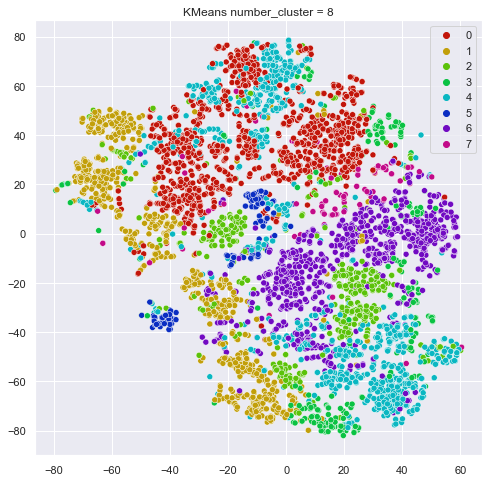

In [32]:
km = KMeans()
predict_km = km.fit_predict(X_working_pca)

palette = sns.hls_palette(km.n_clusters, l=.4, s=.9)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predict_km, palette=palette)
plt.title(label='{name_alg} number_cluster = {n}'.format(name_alg='KMeans', n=km.n_clusters));

### Характеристика кластеров 

In [18]:
data_for_km = data.copy()

data_for_km.insert(loc=2,
                    column='gave_creedite',
                    value=data_for_km['open_account_flg'].values)

data_for_km.insert(loc=2,
                    column='didnt_give_creedit',
                    value=data_for_km['open_account_flg'].map(lambda x: 0 if x == 1 else 1).values)
data_for_km.drop(columns='open_account_flg', inplace=True)

d1 = {i: lambda x: x.median()
     for i in data_for_km.columns if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in data_for_km.columns if not i in continuous_variable_names}
d1.update(d2)

data_for_km['predict'] = predict_km

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
client_profile = data_for_km.groupby(['predict']).agg(d1)
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
clear_cl = client_profile[mas]
clear_cl

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


age  credit_sum  credit_month  monthly_income  credit_count  \
predict                                                                 
0        34.0   20254.500            10         38750.0           2.0   
1        35.0   19345.000            10         26000.0           2.0   
2        38.0   27089.000            10         35000.0           2.0   
3        34.0   21047.730            10         35000.0           2.0   
4        33.0   20532.000            12         35000.0           2.0   
5        33.5   17548.045            10         26500.0           2.0   
6        27.5   19685.000            12         33000.0           2.0   
7        41.5   22524.500            10         27250.0           2.0   

          gender_M   gender_F  didnt_give_creedit  gave_creedite  \
predict                                                            
0        48.979592  51.020408           72.448980      27.551020   
1        57.142857  42.857143           71.428571      28.571429   
2        51.724138  48.275862           93.103448       6.896552   
3        47.887025  52.112975           82.437885      17.562115   
4        43.529412  56.470588           88.235294      11.764706   
5        47.368421  52.631579           78.947368      21.052632   
6        50.000000  50.000000           50.000000      50.000000   
7        50.000000  50.000000           90.000000      10.000000   

         marital_status_WID  marital_status_UNM  marital_status_MAR  \
predict                                                               
0                  1.020408           32.653061           50.000000   
1                  0.000000           28.571429           61.904762   
2                  0.000000           24.137931           58.620690   
3                  2.314717           30.431089           54.894882   
4                  2.352941           29.411765           62.352941   
5                  2.631579           18.421053           63.157895   
6                  0.000000           20.000000           30.000000   
7                 20.000000           20.000000           60.000000   

         marital_status_DIV  marital_status_CIV  job_position_WRP  \
predict                                                             
0                 13.265306            3.061224          1.020408   
1                  4.761905            4.761905          0.000000   
2                 13.793103            3.448276          0.000000   
3                 10.087067            2.272245          0.042472   
4                  5.882353            0.000000          0.000000   
5                 15.789474            0.000000          0.000000   
6                 30.000000           20.000000          0.000000   
7                  0.000000            0.000000         10.000000   

         job_position_WRK  job_position_WOI  job_position_UMN  \
predict                                                         
0               16.326531         12.244898          8.163265   
1                0.000000          0.000000          9.523810   
2                0.000000          0.000000          6.896552   
3                0.000000          0.000000         10.363134   
4                1.176471          0.000000          2.352941   
5                0.000000          0.000000         13.157895   
6               20.000000          0.000000          0.000000   
7                0.000000          0.000000         30.000000   

         job_position_SPC  job_position_PNA  job_position_NOR  \
predict                                                         
0               28.571429          2.040816         16.326531   
1               76.190476          0.000000          0.000000   
2               89.655172          0.000000          0.000000   
3               79.995753          2.357188          0.000000   
4               84.705882          3.529412          0.000000   
5               76.315789          5.263158          0.000000   
6               80.000000

### AgglomerativeClustering

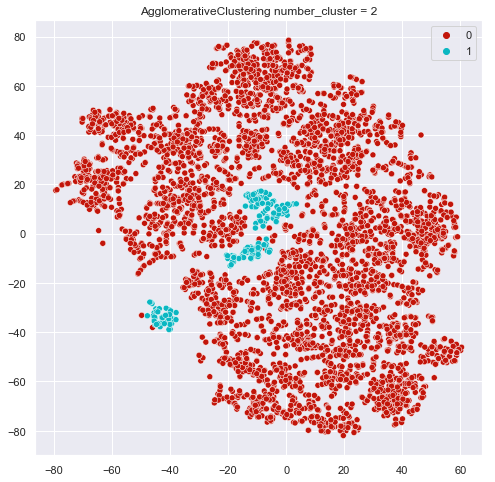

In [34]:
agg = AgglomerativeClustering()
predict_agg = agg.fit_predict(X_working_pca)

palette = sns.hls_palette(agg.n_clusters, l=.4, s=.9)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predict_agg, palette=palette)
plt.title(label='{name_alg} number_cluster = {n}'.format(name_alg='AgglomerativeClustering', n=agg.n_clusters));

In [35]:
data_for_agg = data.copy()

data_for_agg.insert(loc=2,
                    column='gave_creedite',
                    value=data_for_agg['open_account_flg'].values)

data_for_agg.insert(loc=2,
                    column='didnt_give_creedit',
                    value=data_for_agg['open_account_flg'].map(lambda x: 0 if x == 1 else 1).values)
data_for_agg.drop(columns='open_account_flg', inplace=True)

d1 = {i: lambda x: x.median()
     for i in data_for_agg.columns if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in data_for_agg.columns if not i in continuous_variable_names}
d1.update(d2)

data_for_agg['predict'] = predict_agg

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
client_profile = data_for_agg.groupby(['predict']).agg(d1)
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
clear_cl = client_profile[mas]
clear_cl

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


age  credit_sum  credit_month  monthly_income   gender_M   gender_F  \
predict                                                                         
0        34.0    21076.67            10         35000.0  47.942344  52.057656   
1        35.0    19486.00            10         38000.0  46.948357  53.051643   

         didnt_give_creedit  gave_creedite  marital_status_UNM  \
predict                                                          
0                 82.306246      17.693754           30.770838   
1                 81.690141      18.309859           19.248826   

         marital_status_MAR  marital_status_DIV  job_position_UMN  \
predict                                                             
0                 54.501776           10.236056         10.215166   
1                 66.197183            7.981221          9.859155   

         job_position_SPC  tariff_id_1.6  tariff_id_1.5  tariff_id_1.4  \
predict                                                                  
0               79.089200      21.579277       4.219762       6.371423   
1               77.464789      38.967136       7.042254       6.572770   

         tariff_id_1.32  tariff_id_1.1  education_UGR  education_SCH  \
predict                                                                
0              9.588469      41.299352       5.932734      51.430959   
1              4.694836      22.535211       5.633803      46.948357   

         education_GRD  living_region_САНКТПЕТЕРБУРГ  \
predict                                                
0            42.260288                      5.013578   
1            47.417840                      7.042254   

         living_region_МОСКОВСКАЯ  living_region_МОСКВА  \
predict                                                   
0                        8.021726              4.888239   
1                        8.450704              5.164319   

         living_region_КРАСНОДАРСКИЙ  
predict                               
0                           4.742010  
1                           5.633803

# Определение оптимального числа кластеров 

## silhouette_score

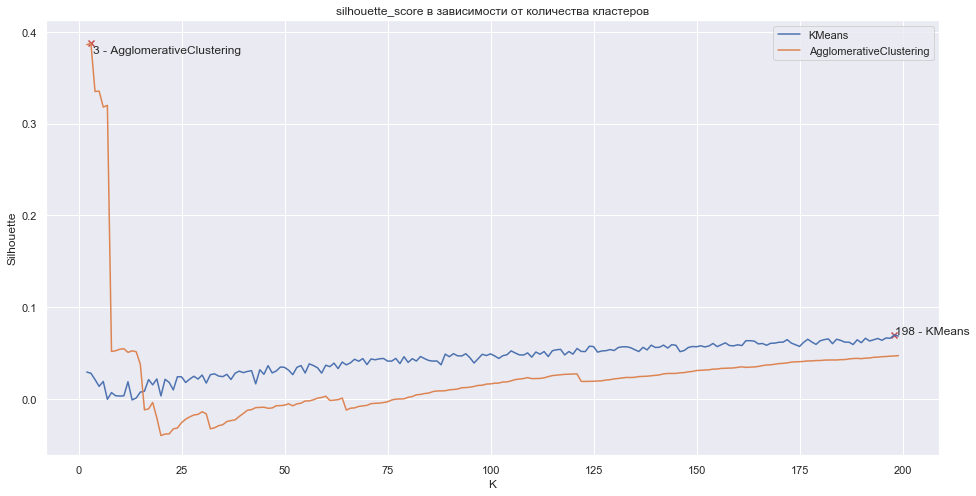

In [36]:
from sklearn.metrics import silhouette_score
silhouette_score_km = [(silhouette_score(X=X_working_pca, labels=KMeans(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 200)]

silhouette_score_agg = [(silhouette_score(X=X_working_pca, labels=AgglomerativeClustering(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 200)]

optimal_number_clusters_km = max(silhouette_score_km)
optimal_number_clusters_agg = max(silhouette_score_agg)

sns.set(rc={'figure.figsize':(16,8)})
plot_km_y, plot_km_x = [i[0] for i in silhouette_score_km], [i[1] for i in silhouette_score_km]
plot_agg_y, plot_agg_x = [i[0] for i in silhouette_score_agg], [i[1] for i in silhouette_score_agg]
plt.plot(plot_km_x, plot_km_y, label='KMeans')
plt.plot(plot_agg_x, plot_agg_y, label='AgglomerativeClustering')
plt.xlabel("K");
plt.ylabel("Silhouette");
plt.title('silhouette_score в зависимости от количества кластеров')

plt.scatter(x=optimal_number_clusters_km[1], y=optimal_number_clusters_km[0], marker='x', c='r')
plt.annotate(s='{label} - KMeans'.format(label=optimal_number_clusters_km[1]),
             xy=(optimal_number_clusters_km[1] + 0.05, optimal_number_clusters_km[0] + 0.0005))

plt.scatter(x=optimal_number_clusters_agg[1], y=optimal_number_clusters_agg[0], marker='x', c='r')
plt.annotate(s='{label} - AgglomerativeClustering'.format(label=optimal_number_clusters_agg[1]),
             xy=(optimal_number_clusters_agg[1] + 0.5, optimal_number_clusters_agg[0] - 0.011))
plt.legend(['KMeans','AgglomerativeClustering']);

Из анализа метрики `silhouette_score` можно установить, что оптимальное число кластеров равно 2. 

### KMeans для n_clusters=198

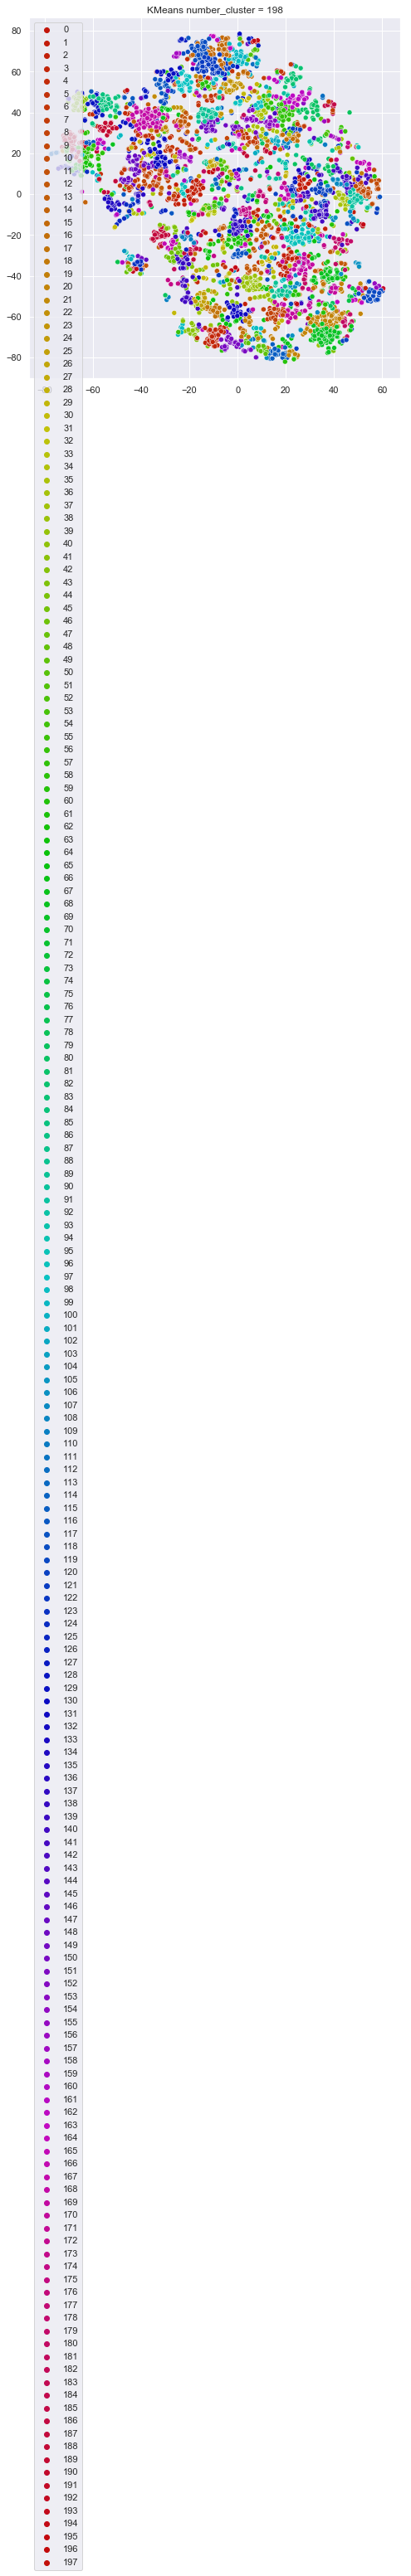

In [37]:
km = KMeans(n_clusters=198)
predict_km = km.fit_predict(X_working_pca)

sns.set(rc={'figure.figsize':(8,8)})
palette = sns.hls_palette(km.n_clusters, l=.4, s=.9)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predict_km, palette=palette)
plt.title(label='{name_alg} number_cluster = {n}'.format(name_alg='KMeans', n=km.n_clusters));

In [38]:
data_for_agg = data.copy()

data_for_agg.insert(loc=2,
                    column='gave_creedite',
                    value=data_for_agg['open_account_flg'].values)

data_for_agg.insert(loc=2,
                    column='didnt_give_creedit',
                    value=data_for_agg['open_account_flg'].map(lambda x: 0 if x == 1 else 1).values)
data_for_agg.drop(columns='open_account_flg', inplace=True)

d1 = {i: lambda x: x.median()
     for i in data_for_agg.columns if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in data_for_agg.columns if not i in continuous_variable_names}
d1.update(d2)

data_for_agg['predict'] = predict_km

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
client_profile = data_for_agg.groupby(['predict']).agg(d1)
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
clear_cl = client_profile[mas]
clear_cl

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


age  credit_sum  credit_month  score_shk  monthly_income  \
predict                                                              
0        37.0   16100.500           5.0   0.561690         54500.0   
1        31.0   39990.000          10.0   0.371133         66000.0   
2        39.0   21141.000          10.0   0.453273         33000.0   
3        29.5   17101.415          10.0   0.609286         25000.0   
4        26.0   30934.500          10.0   0.546872         83500.0   
5        30.0   49434.500          10.0   0.431648         50000.0   
6        29.0   17724.500          10.0   0.506618         41500.0   
7        45.0   20273.000          10.0   0.377931         45000.0   
8        37.0   18162.000          10.0   0.556112         22000.0   
9        28.0   45985.000          10.0   0.479960         55000.0   
10       32.0   12591.000          10.0   0.309478         25000.0   
11       47.0   11638.000          12.0   0.639383         24000.0   
12       36.0   20425.000          10.0   0.430482         35000.0   
13       30.0   18670.450          10.0   0.448332         35000.0   
14       40.0   26790.000          10.0   0.595726        225000.0   
15       41.5   16022.000          10.0   0.375322         40000.0   
16       38.0   42788.000          10.0   0.377877         60000.0   
17       42.0   16778.000          10.0   0.557708         24000.0   
18       37.0   47512.800          10.0   0.488316        250000.0   
19       58.0   18659.000          10.0   0.529759         28000.0   
20       44.0   17016.550          10.0   0.409295         25000.0   
21       26.0   42522.000          24.0   0.571691         40000.0   
22       48.0   26850.000          10.0   0.550125         36500.0   
23       42.0   19527.000          10.0   0.438588         30000.0   
24       45.0   59390.000          10.0   0.361844        250000.0   
25       25.0   16929.000          10.0   0.659989         26000.0   
26       32.0   16818.000          12.0   0.625916         35000.0   
27       29.0   31491.000          12.0   0.490006         45000.0   
28       40.0   37665.000          24.0   0.300679         30000.0   
29       34.5   19653.000          10.0   0.462360         43000.0   
30       36.5   19753.500          11.0   0.517205         44000.0   
31       34.0   60572.500          11.0   0.615605         50000.0   
32       40.0   35822.300          24.0   0.550863         40000.0   
33       35.0   37990.000          24.0   0.440571         51000.0   
34       34.0   18200.640          10.0   0.578264         30000.0   
35       35.0   35748.500          10.0   0.392954         67500.0   
36       44.0   20618.500          10.0   0.393332         25000.0   
37       28.5   36728.500          36.0   0.471158         70500.0   
38       24.0   16498.000          10.0   0.477342         25000.0   
39       40.0   22963.330          10.0   0.267587        300000.0   
40       41.0   18243.500          21.0   0.481434         37500.0   
41       37.0   54688.000          10.0   0.598233         47000.0   
42       25.0   53188.000          10.0   0.629429         40000.0   
43       30.0   18979.000          10.0   0.712815         30000.0   
44       41.0   16015.340          12.0   0.673749         34000.0   
45       31.0   19970.000          10.0   0.461959         40000.0   
46       33.0   57791.500          10.0   0.554533         72000.0   
47       42.0   15838.000          10.0   0.669863         30750.0   
48       52.0   17450.000          10.0   0.296286         65000.0   
49       60.0   20373.000          10.0   0.606966         24700.0   
50       27.5   41456.000          24.0   0.439984         51500.0   
51       43.0   11258.000           6.0   0.303930         25000.0   
52       34.0   12999.000          24.0   0.371466        110000.0   
53       34.5   20629.000          10.0   0.450868         40500.0   
54       36.0   12074.500          10.0   0.453815         32500.0   
55       56.0   9738

### AgglomerativeClustering для n_clusters=3

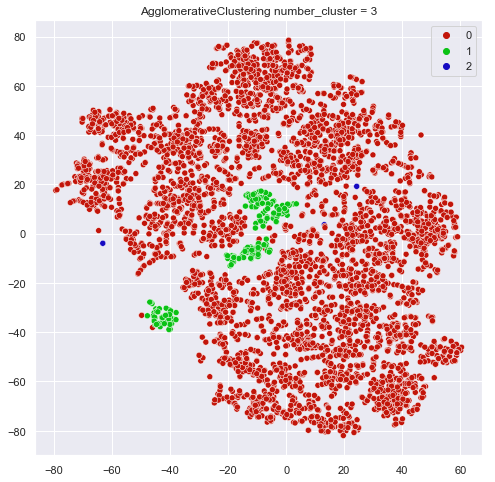

In [45]:
agg = AgglomerativeClustering(n_clusters=3)
predict_agg = agg.fit_predict(X_working_pca)

sns.set(rc={'figure.figsize':(8,8)})
palette = sns.hls_palette(agg.n_clusters, l=.4, s=.9)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=predict_agg, palette=palette)
plt.title(label='{name_alg} number_cluster = {n}'.format(name_alg='AgglomerativeClustering', n=agg.n_clusters));

In [46]:
data_for_agg = data.copy()

data_for_agg.insert(loc=2,
                    column='gave_creedite',
                    value=data_for_agg['open_account_flg'].values)

data_for_agg.insert(loc=2,
                    column='didnt_give_creedit',
                    value=data_for_agg['open_account_flg'].map(lambda x: 0 if x == 1 else 1).values)
data_for_agg.drop(columns='open_account_flg', inplace=True)

d1 = {i: lambda x: x.median()
     for i in data_for_agg.columns if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in data_for_agg.columns if not i in continuous_variable_names}
d1.update(d2)

data_for_agg['predict'] = predict_agg

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
client_profile = data_for_agg.groupby(['predict']).agg(d1)
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
clear_cl = client_profile[mas]
clear_cl

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


age  credit_sum  credit_month  monthly_income   gender_M   gender_F  \
predict                                                                         
0        34.0     21067.0            10         35000.0  47.908825  52.091175   
1        35.0     19486.0            10         38000.0  46.948357  53.051643   
2        40.0     26790.0            10        287500.0  80.000000  20.000000   

         didnt_give_creedit  gave_creedite  marital_status_UNM  \
predict                                                          
0                 82.329569      17.670431           30.782100   
1                 81.690141      18.309859           19.248826   
2                 60.000000      40.000000           20.000000   

         marital_status_MAR  marital_status_DIV  job_position_UMN  \
predict                                                             
0                 54.516939           10.204935         10.225847   
1                 66.197183            7.981221          9.859155   
2                 40.000000           40.000000          0.000000   

         job_position_SPC  job_position_BIS  tariff_id_1.6  tariff_id_1.5  \
predict                                                                     
0               79.130071          3.283145      21.580928       4.203262   
1               77.464789          4.694836      38.967136       7.042254   
2               40.000000         60.000000      20.000000      20.000000   

         tariff_id_1.4  tariff_id_1.32  tariff_id_1.1  education_UGR  \
predict                                                                
0             6.357173        9.556671      41.342535       5.918026   
1             6.572770        4.694836      22.535211       5.633803   
2            20.000000       40.000000       0.000000      20.000000   

         education_SCH  education_GRD  living_region_СВЕРДЛОВСКАЯ  \
predict                                                             
0            51.421999      42.283563                    3.011292   
1            46.948357      47.417840                    4.225352   
2            60.000000      20.000000                   20.000000   

         living_region_САНКТПЕТЕРБУРГ  living_region_НЕНЕЦКИЙ  \
predict                                                         
0                            5.018821                0.104559   
1                            7.042254                0.938967   
2                            0.000000               20.000000   

         living_region_МОСКОВСКАЯ  living_region_МОСКВА  \
predict                                                   
0                        7.988289              4.893350   
1                        8.450704              5.164319   
2                       40.000000              0.000000   

         living_region_КРАСНОДАРСКИЙ  living_region_КАРЕЛИЯ  
predict                                                      
0                           4.746968               0.418235  
1                           5.633803               0.000000  
2                           0.000000              20.000000

### davies_bouldin_score

Более низкие значения указывают на лучшую кластеризацию.

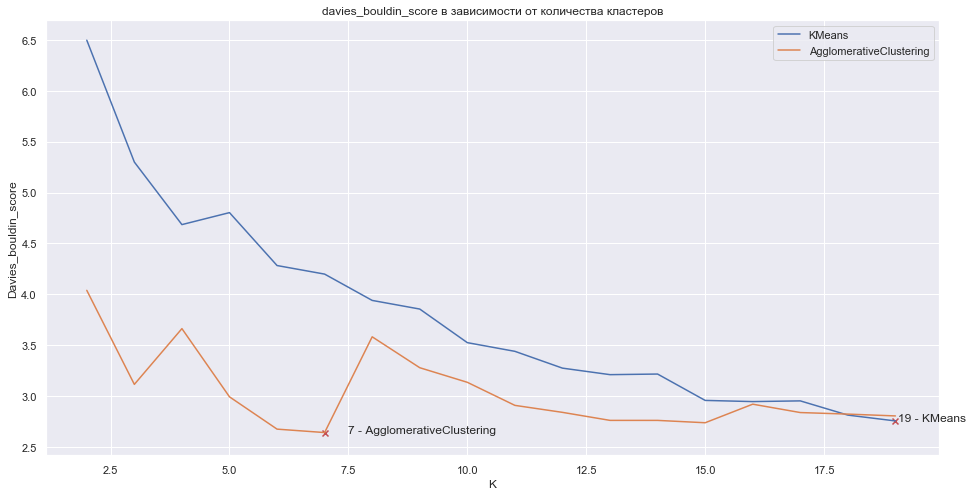

In [41]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score_km = [(davies_bouldin_score(X=X_working_pca, labels=KMeans(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 20)]

davies_bouldin_score_agg = [(davies_bouldin_score(X=X_working_pca, labels=AgglomerativeClustering(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 20)]

optimal_number_clusters_km = min(davies_bouldin_score_km)
optimal_number_clusters_agg = min(davies_bouldin_score_agg)

sns.set(rc={'figure.figsize':(16,8)})
plot_km_y, plot_km_x = [i[0] for i in davies_bouldin_score_km], [i[1] for i in davies_bouldin_score_km]
plot_agg_y, plot_agg_x = [i[0] for i in davies_bouldin_score_agg], [i[1] for i in davies_bouldin_score_agg]
plt.plot(plot_km_x, plot_km_y, label='KMeans')
plt.plot(plot_agg_x, plot_agg_y, label='AgglomerativeClustering')
plt.xlabel("K");
plt.ylabel("Davies_bouldin_score");
plt.title('davies_bouldin_score в зависимости от количества кластеров')

plt.scatter(x=optimal_number_clusters_km[1], y=optimal_number_clusters_km[0], marker='x', c='r')
plt.annotate(s='{label} - KMeans'.format(label=optimal_number_clusters_km[1]),
             xy= (optimal_number_clusters_km[1] + 0.05, optimal_number_clusters_km[0] + 0.0005))

plt.scatter(x=optimal_number_clusters_agg[1], y=optimal_number_clusters_agg[0], marker='x', c='r')
plt.annotate(s='{label} - AgglomerativeClustering'.format(label=optimal_number_clusters_agg[1]),
             xy=(optimal_number_clusters_agg[1] + 0.5, optimal_number_clusters_agg[0] - 0.011))
plt.legend(['KMeans','AgglomerativeClustering']);

Kmeans - 19
<br>AgglomerativeClustering - 19
<br>Метрика показывает что оптимальное число равно 19 кластеров для двух алгоритмов 

### v_measure_score

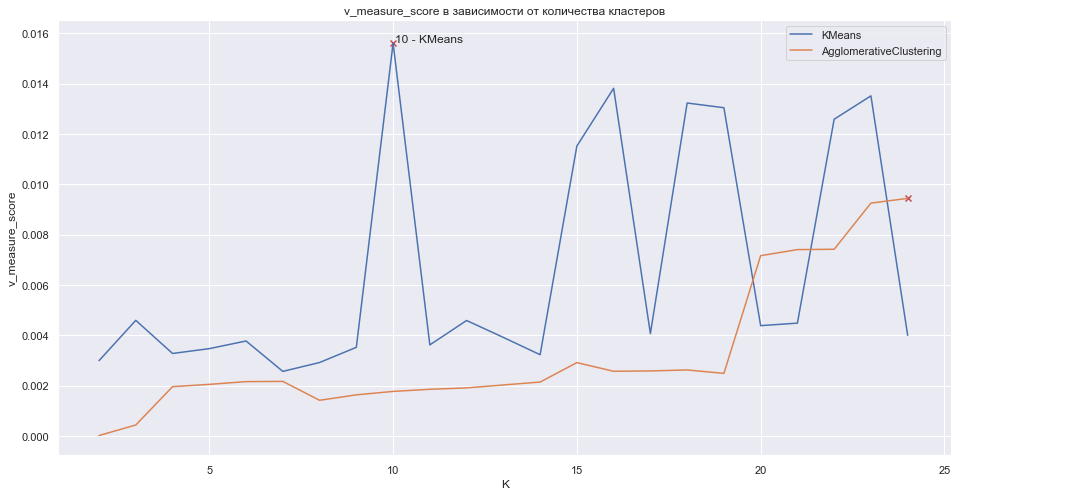

In [47]:
from sklearn.metrics import v_measure_score

v_measure_score_km = [(v_measure_score(labels_true=y.open_account_flg.to_numpy(), labels_pred=KMeans(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 25)]

v_measure_score_agg = [(v_measure_score(labels_true=y.open_account_flg.to_numpy(), labels_pred=AgglomerativeClustering(n_clusters=i).fit_predict(X_working_pca)), i)
                       for i in range(2, 25)]

optimal_number_clusters_km = max(v_measure_score_km)
optimal_number_clusters_agg = max(v_measure_score_agg)

sns.set(rc={'figure.figsize':(16,8)})
plot_km_y, plot_km_x = [i[0] for i in v_measure_score_km], [i[1] for i in v_measure_score_km]
plot_agg_y, plot_agg_x = [i[0] for i in v_measure_score_agg], [i[1] for i in v_measure_score_agg]
plt.plot(plot_km_x, plot_km_y, label='KMeans')
plt.plot(plot_agg_x, plot_agg_y, label='AgglomerativeClustering')
plt.xlabel("K");
plt.ylabel("v_measure_score");
plt.title('v_measure_score в зависимости от количества кластеров')

plt.scatter(x=optimal_number_clusters_km[1], y=optimal_number_clusters_km[0], marker='x', c='r')
plt.annotate(s='{label} - KMeans'.format(label=optimal_number_clusters_km[1]),
             xy= (optimal_number_clusters_km[1] + 0.05, optimal_number_clusters_km[0] + 0.00005))

plt.scatter(x=optimal_number_clusters_agg[1], y=optimal_number_clusters_agg[0], marker='x', c='r')
plt.annotate(s='{label} - AgglomerativeClustering'.format(label=optimal_number_clusters_agg[1]),
             xy=(optimal_number_clusters_agg[1] + 0.05, optimal_number_clusters_agg[0] - 0.011))
plt.legend(['KMeans','AgglomerativeClustering']);

### Профиль клиента

In [ ]:
data_client_profile = data.copy()

data_client_profile.insert(loc=2,
                    column='gave_creedite',
                    value=data_client_profile['open_account_flg'].values)

data_client_profile.insert(loc=2,
                    column='didnt_give_creedit',
                    value=data_client_profile['open_account_flg'].map(lambda x: 0 if x == 1 else 1).values)
data_client_profile.drop(columns='open_account_flg', inplace=True)

d1 = {i: lambda x: x.median()
     for i in data_client_profile.columns if (i in continuous_variable_names)}

d2= {i: lambda x: (x.sum()/len(x))*100 for i in data_client_profile.columns if not i in continuous_variable_names}
d1.update(d2)
data_client_profile['predict'] = predict_km

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

client_profile = data_client_profile.groupby(['predict']).agg(d1)

# mas
mas = [i for i in client_profile.columns if sum(client_profile[i]) > 10]
clear_cl = client_profile[mas]



### max
new_column = ['marital_status', 'job_position', 'tariff_id', 'education', 'living_region']
categorical_groups = {i: [re.sub(pattern=i+'_', repl='', string=j)
                          for j in client_profile.columns if re.match(pattern=i, string=j)] for i in new_column}

new_client_profile=client_profile[['age', 'credit_sum', 'credit_month', 'score_shk',
                                   'monthly_income', 'credit_count', 'overdue_credit_count',
                                   'gender_M', 'gender_F', 'didnt_give_creedit', 'gave_creedite']]

def fun_returning_tags_category(column):
    test = client_profile[[column+'_'+group for group in categorical_groups[column]]]
    test.insert(loc=len(test.columns),
               column=column,
               value=[re.sub(pattern=column+'_',
                             repl='',
                             string=test.loc[i][test.loc[i] == test.loc[i].max()].index[0]) for i in test.index])
    test.drop(columns=[column+'_'+group for group in categorical_groups[column]], inplace=True)
    return test

new_client_profile = pd.concat([new_client_profile]+[fun_returning_tags_category(column=column)
                                                     for column in new_column], axis=1)
new_client_profile